In [1]:
import nltk
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize,PorterStemmer
import re
import string
import matplotlib.pyplot as plt

## Hotel Recommender

#### Reading Data

In [275]:
hotels =  pd.read_csv('../datasets/hotel_features_dataset.csv')
hotels = hotels.drop('Unnamed: 0',axis=1)

In [276]:
hotels.head()

,name,country,street,region,rating,reviews,amenities,rooms,types,price,official_description
0,WH Hotel,Lebanon,Lyon Street Hamra Emille Edde,NaN,4.0,"{'Excellent': 104, 'Good': 102, 'Average': 51,...","Free High Speed Internet (WiFi),Free breakfast...","Air conditioning,Fireplace,Housekeeping,Room s...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN
1,Le Patio Boutique Hotel,Lebanon,"1144 Marfaa, Uruguay Street Solidere",NaN,4.5,"{'Excellent': 213, 'Good': 78, 'Average': 31, ...","Paid private parking nearby,Free High Speed In...","Air conditioning,Housekeeping,Room service,Saf...","Non-smoking rooms,Suites,Family rooms,Smoking ...",121.0,NaN
2,Riviera Hotel Beirut,Lebanon,"Avenue De Paris, Corniche El Manara Riad El Solh",NaN,3.5,"{'Excellent': 90, 'Good': 101, 'Average': 69, ...","Valet parking,Free High Speed Internet (WiFi),...","Air conditioning,Private balcony,Room service,...","Ocean view,Pool view,Non-smoking rooms,Suites,...",NaN,NaN
3,Le Bristol Beyrouth,Lebanon,Mme Curie Street Verdun,NaN,4.5,"{'Excellent': 219, 'Good': 79, 'Average': 25, ...","Free High Speed Internet (WiFi),Pool,Fitness C...","Air conditioning,Room service,Safe,VIP room fa...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN
4,Golden Tulip Midtown Hotel And Suites,Lebanon,"Building Number 483, Sidani / Souraty Street M...",NaN,4.0,"{'Excellent': 147, 'Good': 86, 'Average': 32, ...","Free parking,Free High Speed Internet (WiFi),P...","Air conditioning,Room service,Safe,Kitchenette...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN


### Feature Extraction

In [277]:
features = set()

In [278]:
groups = pd.DataFrame(hotels['country'].value_counts().head(20))
groups.sort_values(by='country',ascending=False)

,country
United States,12243
United Kingdom,5726
Italy,5071
France,3481
Turkey,3405
India,3145
Spain,2761
Greece,2254
Germany,1936
Australia,1865


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

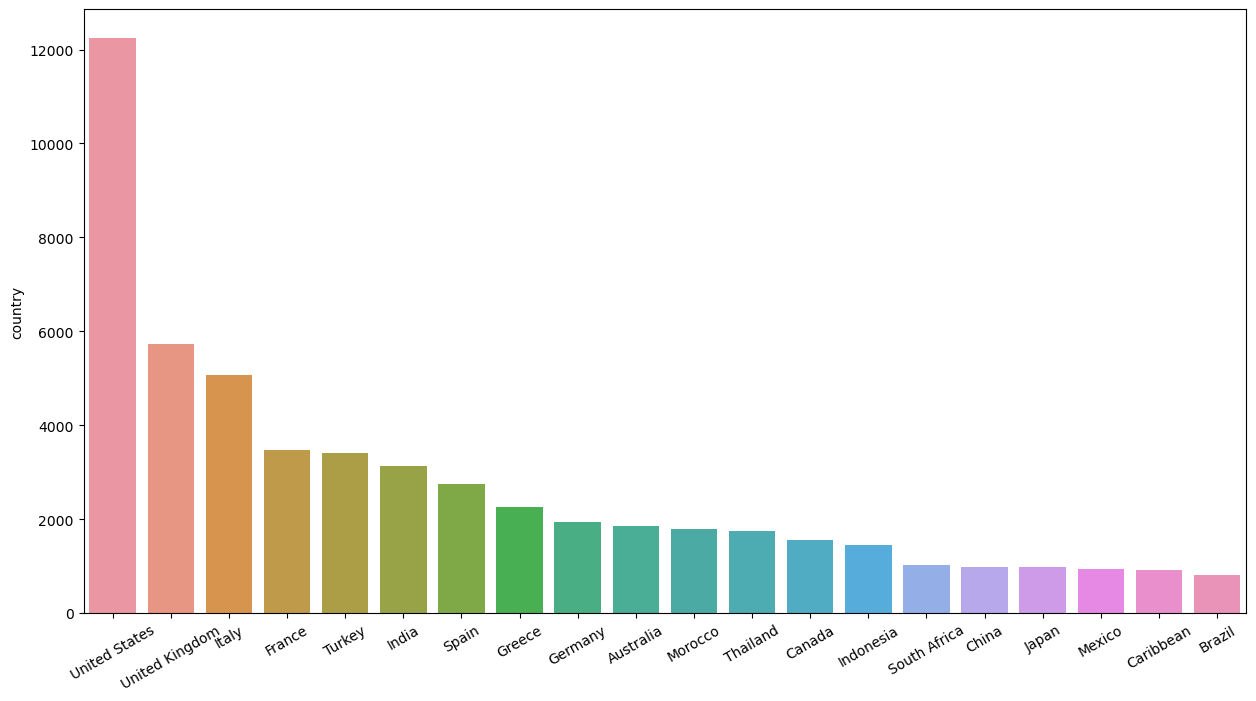

In [279]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15,8), dpi=100, facecolor='w', edgecolor='r')
sns.barplot(x=groups.index,y=groups['country'],data=groups,orient='v')
plt.xticks(rotation=30)

In [323]:
stars = hotels.groupby('rating')['name'].count()
stars

rating
0.0      449
1.0       18
1.5      168
2.0      642
2.5     1760
3.0     4743
3.5    11033
4.0    21324
4.5    23476
5.0     9460
Name: name, dtype: int64

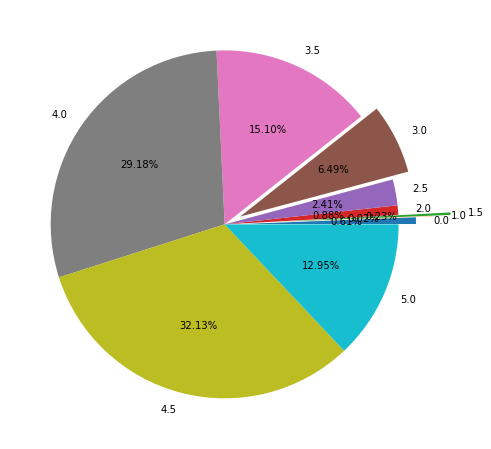

In [324]:
fig1,ax1 = plt.subplots(figsize=(8,8))
ax1.pie(stars,labels=stars.index,explode= (0.1, 0.2,0.3,0,0,0.1, 0, 0,0,0), autopct='%1.2f%%' )
plt.show()

In [368]:
hotels['amenities'].apply(lambda item: [features.add(x) for x in str(item).split(',')])
hotels['rooms'].apply(lambda item: [features.add(x) for x in str(item).split(',')])
hotels['types'].apply(lambda item: [features.add(x) for x in str(item).split(',')])

print()

In [369]:
features

{' DVDs',
 ' music for children',
 '24-hour check-in',
 '24-hour front desk',
 '24-hour security',
 'ATM on site',
 'Additional bathroom',
 'Adult pool',
 'Adults only',
 'Aerobics',
 'Aerobics offsite',
 'Air conditioning',
 'Air purifier',
 'Airport transportation',
 'Allergy-free room',
 'Archery',
 'Archery offsite',
 'BBQ facilities',
 'Babysitting',
 'Badminton',
 'Baggage storage',
 'Banquet room',
 'Bar / lounge',
 'Bath / shower',
 'Bathrobes',
 'Beach',
 'Bicycle rental',
 'Bicycle tours',
 'Bicycles available',
 'Bidet',
 'Billiards',
 'Blackout curtains',
 'Board games / puzzles',
 'Boating',
 'Body wrap',
 'Books',
 'Bottled water',
 'Bowling',
 'Bowling offsite',
 'Breakfast available',
 'Breakfast buffet',
 'Breakfast in the room',
 'Bridal suite',
 'Business Center with Internet Access',
 'Butler service',
 'Cable / satellite TV',
 'Canoeing',
 'Canoeing offsite',
 'Car hire',
 'Casino and Gambling',
 'Chapel / shrine',
 'Children Activities (Kid / Family Friendly)',
 "

In [370]:
features = {x for x in features if pd.notna(x) or x != ''}

In [371]:
features.discard('')
features.discard('nan')
# features.discard(' DVDs')
# features.discard(' music for children')

In [372]:
features

{' DVDs',
 ' music for children',
 '24-hour check-in',
 '24-hour front desk',
 '24-hour security',
 'ATM on site',
 'Additional bathroom',
 'Adult pool',
 'Adults only',
 'Aerobics',
 'Aerobics offsite',
 'Air conditioning',
 'Air purifier',
 'Airport transportation',
 'Allergy-free room',
 'Archery',
 'Archery offsite',
 'BBQ facilities',
 'Babysitting',
 'Badminton',
 'Baggage storage',
 'Banquet room',
 'Bar / lounge',
 'Bath / shower',
 'Bathrobes',
 'Beach',
 'Bicycle rental',
 'Bicycle tours',
 'Bicycles available',
 'Bidet',
 'Billiards',
 'Blackout curtains',
 'Board games / puzzles',
 'Boating',
 'Body wrap',
 'Books',
 'Bottled water',
 'Bowling',
 'Bowling offsite',
 'Breakfast available',
 'Breakfast buffet',
 'Breakfast in the room',
 'Bridal suite',
 'Business Center with Internet Access',
 'Butler service',
 'Cable / satellite TV',
 'Canoeing',
 'Canoeing offsite',
 'Car hire',
 'Casino and Gambling',
 'Chapel / shrine',
 'Children Activities (Kid / Family Friendly)',
 "

In [373]:
features_df = pd.DataFrame(columns=features)

In [374]:
features_df

,hotel_amenity_water_park_offsite,hotel_amenity_billiards,Street parking,hotel_amenity_allergy_free_room,hotel_amenity_snorkeling,Free breakfast,Fishing,Microwave,Paid private parking on-site,Archery offsite,...,Wardrobe / closet,Flatscreen TV,amenity_fitness_center_title_ad3,hotel_amenity_evening_entertainment,Free shuttle or taxi services,hotel_amenity_concierge,Banquet room,Seating area,hotel_amenity_childrens_television_networks,Pool with view


#### Getting each hotel feature as a Vector

In [388]:
amenities  = hotels['amenities'] + ',' +  hotels['rooms'] + ',' +  hotels['types']
amenities[0]

'Free High Speed Internet (WiFi),Free breakfast,Airport transportation,Business Center with Internet Access,Conference facilities,Baggage storage,Concierge,Dry cleaning,Wifi,Bar / lounge,Restaurant,Breakfast available,Breakfast buffet,Car hire,Banquet room,Meeting rooms,Currency exchange,Laundry service,Air conditioning,Fireplace,Housekeeping,Room service,Minibar,Refrigerator,Flatscreen TV,Non-smoking rooms,Suites,Family rooms,Smoking rooms available,Air conditioning,Fireplace,Housekeeping,Room service,Minibar,Refrigerator,Flatscreen TV,Non-smoking rooms,Suites,Family rooms,Smoking rooms available,Non-smoking rooms,Suites,Family rooms,Smoking rooms available'

In [1]:
def extract_features(amenities,features) -> list:
    hotel_features = []
    col_names = pd.Index(features)
    for i,amenity in enumerate(amenities):
        if pd.notna(amenity):
            feats = amenity.split(',')
            row = np.zeros(len(features))
            for feat in feats:
                if feat != '':
                    index = np.where(col_names == feat)[0][0] #index
                    row[index] = 1
            hotel_features.append(row)
    return hotel_features


In [12]:
hotel_features = extract_features(amenities,features)

NameError: name 'amenities' is not defined

In [380]:
features_df = pd.DataFrame(hotel_features,columns= features)
features_df.head()

,hotel_amenity_water_park_offsite,hotel_amenity_billiards,Street parking,hotel_amenity_allergy_free_room,hotel_amenity_snorkeling,Free breakfast,Fishing,Microwave,Paid private parking on-site,Archery offsite,...,Wardrobe / closet,Flatscreen TV,amenity_fitness_center_title_ad3,hotel_amenity_evening_entertainment,Free shuttle or taxi services,hotel_amenity_concierge,Banquet room,Seating area,hotel_amenity_childrens_television_networks,Pool with view
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [389]:
# add location feature
locations = set(hotels['country'])
locations_list = [c for c in locations]
features_df['country'] = hotels['country'].apply(lambda loc: locations_list.index(loc))
features_df['country']

0         35
1         35
2         35
3         35
4         35
        ... 
62714    124
62715    124
62716     60
62717    151
62718    170
Name: country, Length: 62719, dtype: int64

'Hi How are You'

In [390]:
hotels_names = hotels['name']

In [391]:
features_df = features_df.rename(index=hotels_names)
features_df.head()

,hotel_amenity_water_park_offsite,hotel_amenity_billiards,Street parking,hotel_amenity_allergy_free_room,hotel_amenity_snorkeling,Free breakfast,Fishing,Microwave,Paid private parking on-site,Archery offsite,...,Flatscreen TV,amenity_fitness_center_title_ad3,hotel_amenity_evening_entertainment,Free shuttle or taxi services,hotel_amenity_concierge,Banquet room,Seating area,hotel_amenity_childrens_television_networks,Pool with view,country
WH Hotel,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35
Le Patio Boutique Hotel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
Riviera Hotel Beirut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35
Le Bristol Beyrouth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35
Golden Tulip Midtown Hotel And Suites,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35


### KNN Content-Based Recommender

In [392]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [393]:
knn = NearestNeighbors(n_neighbors=20,metric='cosine')

In [394]:
knn.fit(features_df)

NearestNeighbors(metric='cosine', n_neighbors=20)

In [395]:
distances,indecies = knn.kneighbors(features_df)

In [396]:
features_df.shape

(62719, 480)

In [397]:
tsne = TSNE(n_components=2).fit_transform(indecies[:1000])

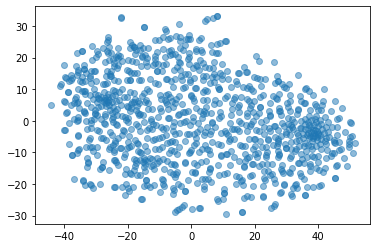

In [398]:
plt.scatter(tsne[:,0],tsne[:,1],alpha=0.5)

### Get Recommendation

In [399]:
def get_recommendation(name,k_indecies,k_distances,features_df,df):
    index = np.where(features_df.index == name)
    neighbours =  k_indecies[index].tolist()[0][1:21]
    distance = k_distances[index][0].tolist()
    for i,neighbour in enumerate(neighbours):
            print(df['name'].loc[neighbour],':',1 - distance[i+1])

In [400]:
get_recommendation('Hotel Pamphylia',indecies,distances,features_df,hotels)

Collage Taksim : 0.9996295154021394
Bika Suites Istanbul Hotel : 0.9996100368684652
The Westist Hotel & Spa : 0.9996100186151232
Nova Plaza Taksim Square : 0.9995905077550907
Hotel & Suites PF : 0.9995900523771325
B&B Valentina : 0.9995823395867114
Tolga Hotel : 0.9995710284632365
Anka Hotel : 0.9995709980346306
BAD | B&B and Design : 0.9995607389733772
Hotel Fatih Istanbul : 0.9995515624734108
Milport Hotel Levent Istanbul : 0.9995515350981435
Akgun Hotel : 0.9995515350981435
Seven Hills Hotel - Special Category : 0.9995515236897455
Prima Hotel : 0.9995515236897455
Metin Han : 0.9995514894543432
Grand Palace Hotel : 0.9995514894543432
The Richmond Arms : 0.999541186664704
Mia Lodge B&B & Hostel : 0.9995369769239643
Miss Istanbul Hotel & Spa : 0.9995320907743898


In [86]:
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm

In [289]:
def similarity(one,two,df):
    one = df.loc[one]
    two = df.loc[two]
    return np.dot(one,two)/ np.multiply(norm(one),norm(two))

In [290]:
similarity("Hampton Inn Suites Bolingbrook","Warwick Stone 55 Hotel",features_df)

0.9994265631819792